In [27]:
# Imports and basic configuration
import warnings, math
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter("ignore", InterpolationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statsmodels for unit-root tests, STL, ACF/PACF
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import STL
try:
    from statsmodels.tsa.stattools import zivot_andrews
    HAS_ZA = True
except Exception:
    HAS_ZA = False

try:
    from statsmodels.tsa.stattools import phillips_perron
    HAS_PP = True
except Exception:
    HAS_PP = False

# change point detection
try:
    import ruptures as rpt
    HAS_RUPTURES = True
except Exception:
    HAS_RUPTURES = False

from scipy.stats import ks_2samp, cramervonmises_2samp


# config
L = 7                           # lead time
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# columns needed
KEYS = ["id", "date", "sales", "sell_price", "is_event", "snap", "wday", "year",
        "month_nb", "weekday_nb", "weekofyear_nb", "dayofyear", "split"]

# Load data 
df = pd.read_csv(r"C:\Users\Bindhu\Documents\!Thesis\m5_final\Data\m5_final.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["id", "date"]).reset_index(drop=True)


In [28]:
# Constructing forward-looking lead-time demand D_t^L
def make_lead_time_demand(frame: pd.DataFrame, L: int) -> pd.DataFrame:
    # grouping by series id so each time series is handled independently
    g = frame.groupby("id", group_keys=False)
    # computing rolling sum over the next L days and aligning to current t
    fwd_sum = g["sales"].transform(lambda x: x.rolling(L).sum().shift(-(L-1)))
    frame = frame.copy()
    frame["D_L"] = fwd_sum
    # dropping tail positions where future is not available
    frame = frame[np.isfinite(frame["D_L"])].reset_index(drop=True)
    return frame

df = make_lead_time_demand(df, L=L)

# defining a simple half/half split per series to compare drift robustly
def add_halves(frame: pd.DataFrame) -> pd.DataFrame:
    out = []
    for sid, grp in frame.groupby("id"):
        n = len(grp)
        tag = np.array(["H1"]* (n//2) + ["H2"]* (n - n//2))
        grp = grp.copy()
        grp["half"] = tag
        out.append(grp)
    return pd.concat(out, axis=0, ignore_index=True)

df = add_halves(df)


In [29]:
# Running unit-root and stationarity tests on each product–store time series.
#   ADF: H0 = unit root (non-stationary)
#   KPSS (c, ct): H0 = stationary (level or trend)
#   Zivot–Andrews: H0 = unit root with one structural break allowed
#   Phillips–Perron: H0 = unit root, robust to serial correlation/heteroskedasticity


# Augmented Dickey–Fuller test that returns test statistic and p-value
def safe_adf(x):
    try:
        res = adfuller(x, autolag="AIC")
        return {"stat": res[0], "p": res[1]}
    except Exception:
        return {"stat": np.nan, "p": np.nan}

# KPSS test (level or trend) that returns statistic and p-value
def safe_kpss(x, regression="c"):
    try:
        stat, p, *_ = kpss(x, regression=regression, nlags="auto")
        return {"stat": stat, "p": p}
    except Exception:
        return {"stat": np.nan, "p": np.nan}

# Zivot–Andrews test to check for one structural break
def safe_za(x):
    if not HAS_ZA:
        return {"stat": np.nan, "p": np.nan}
    try:
        stat, p, *_ = zivot_andrews(x, trim=0.15)
        return {"stat": stat, "p": p}
    except Exception:
        return {"stat": np.nan, "p": np.nan}

# Phillips–Perron test for a robust unit-root check
def safe_pp(x):
    if not HAS_PP:
        return {"stat": np.nan, "p": np.nan}
    try:
        stat, p, *_ = phillips_perron(x)
        return {"stat": stat, "p": p}
    except Exception:
        return {"stat": np.nan, "p": np.nan}

# Applying tests to every series

rows = []
# Looping through each product–store combination
for sid, grp in df.groupby("id"):
    # Converting sales to float array for testing
    y = grp["sales"].astype(float).to_numpy()
    # Skipping very short series because tests need enough observations
    if len(y) < 30:
        continue
    # Running each test and collecting p-values
    adf_res  = safe_adf(y)
    kpss_c   = safe_kpss(y, regression="c")
    kpss_ct  = safe_kpss(y, regression="ct")
    za_res   = safe_za(y)
    pp_res   = safe_pp(y)

    rows.append({
        "id": sid,
        "ADF_p": adf_res["p"],
        "KPSS_c_p": kpss_c["p"],
        "KPSS_ct_p": kpss_ct["p"],
        "ZA_p": za_res["p"],
        "PP_p": pp_res["p"]
    })

unit_tests = pd.DataFrame(rows)

# significance level
alpha = 0.05
# Computing share of series where each test rejects its null hypothesis
summary = {
    "ADF rejects unit root (stationary)": np.mean(unit_tests["ADF_p"] < alpha),
    "KPSS(c) rejects stationarity":       np.mean(unit_tests["KPSS_c_p"] < alpha),
    "KPSS(ct) rejects stationarity":      np.mean(unit_tests["KPSS_ct_p"] < alpha),
    "ZA rejects unit root (stationary w/ break)": np.mean(unit_tests["ZA_p"] < alpha) if HAS_ZA else np.nan,
    "PP rejects unit root (stationary)":  np.mean(unit_tests["PP_p"] < alpha) if HAS_PP else np.nan,
}

print(pd.Series(summary).apply(lambda x: f"{x:.1%}" if pd.notna(x) else "NA"))

ADF rejects unit root (stationary)              1.0%
KPSS(c) rejects stationarity                  100.0%
KPSS(ct) rejects stationarity                  99.6%
ZA rejects unit root (stationary w/ break)     72.4%
PP rejects unit root (stationary)                 NA
dtype: object


Statistical tests show that the demand series are not stationary. Only about 1 % of the series pass the Augmented Dickey–Fuller (ADF) test, which would mean they are stationary. In contrast, the KPSS test rejects stationarity for almost all series. It rejects 100 % when testing for level stationarity and 99.6 % even when a linear trend is allowed.

The Zivot–Andrews test, which allows for one sudden change in level or trend, rejects the unit-root null in about 72 % of the series. This suggests that many series could be trend-stationary if just a single break explained their changes. But the KPSS results show that one break is not enough. Most series have several structural changes, varying volatility, and shifting seasonal patterns.

These findings mean that simple stationary models cannot describe the demand data well. The evidence supports using dynamic, context-aware models instead of assuming a fixed distribution.

In [30]:
# Measuring distributional shift in 'sales' within each series.
# Two comparisons are used:
#   1) First half vs second half of the series (within-id)
#   2) Each year vs the first observed year for that id
# Tests:
#   KS  : Kolmogorov–Smirnov two-sample test
#   CVM : Cramér–von Mises two-sample test


# Computing KS and CVM statistics between halves for one series
def dist_shift_metrics(grp):
    # Spliting the series into first half (H1) and second half (H2)
    a = grp.loc[grp["half"] == "H1", "sales"].astype(float).to_numpy()
    b = grp.loc[grp["half"] == "H2", "sales"].astype(float).to_numpy()
    # Guarding against very short halves where tests are unreliable
    if len(a) < 10 or len(b) < 10:
        return None
    # Run KS test to detect any distributional difference
    ks = ks_2samp(a, b, alternative="two-sided", mode="auto")
    # Run CVM test for an additional distributional check
    cvm = cramervonmises_2samp(a, b)
    return {
        "KS_stat": ks.statistic, "KS_p": ks.pvalue,
        "CVM_stat": cvm.statistic, "CVM_p": cvm.pvalue
    }

# Collecting half-vs-half drift metrics across all ids
shift_rows = []
for sid, grp in df.groupby("id"):
    # Compute drift metrics for this id
    m = dist_shift_metrics(grp)
    if m:
        m["id"] = sid
        shift_rows.append(m)

shift_df = pd.DataFrame(shift_rows)

print("Share with significant drift (KS p<0.05):",
      f"{np.mean(shift_df['KS_p'] < 0.05):.1%}")
print("Share with significant drift (CVM p<0.05):",
      f"{np.mean(shift_df['CVM_p'] < 0.05):.1%}")


# Storing KS results for each (id, year vs base-year) comparison
yb_rows = []
for sid, grp in df.groupby("id"):
    # Identify the base year for this id
    basey = grp["year"].min()
    # Loop over years in chronological order
    for y in sorted(grp["year"].unique()):
        # Skipping the base year because it is the reference
        if y == basey:
            continue
        # Extracting sales for base year and current year
        a = grp.loc[grp["year"] == basey, "sales"].to_numpy()
        b = grp.loc[grp["year"] == y, "sales"].to_numpy()
        if len(a) >= 10 and len(b) >= 10:
            # Running KS test to compare base year vs current year
            ks = ks_2samp(a, b)
            yb_rows.append({
                "id": sid, "year": int(y), "base": int(basey),
                "KS_stat": ks.statistic, "KS_p": ks.pvalue
            })

year_drift = pd.DataFrame(yb_rows)


Share with significant drift (KS p<0.05): 98.0%
Share with significant drift (CVM p<0.05): 98.0%


The comparison of the first and second halves of each series shows strong distributional drift. The Kolmogorov–Smirnov (KS) test and the Cramér–von Mises (CVM) test both detect significant differences between the two halves for about 98 % of the series.

This means that the statistical distribution of demand changes over time for almost every product–store combination. Such a high rate of detected drift provides further evidence of non-stationarity and supports the need for dynamic models instead of approaches that assume a stable demand distribution.

In [31]:
# Visualising a few SKUs in detail
# Strategy: rank ids by KS_stat and take the top 3 with the largest shift
top_ids = (
    shift_df.sort_values("KS_stat", ascending=False)
            .head(3)["id"].tolist()
)

# Building a compact diagnostic plot for one id
# Panels:
#   (1) Levels with 28-day rolling mean and rolling std
#   (2) STL decomposition to separate trend and seasonal parts
#   (3) ACF snapshot for the first 30 lags
#   (4) Add change points with ruptures

def plot_series_diagnostics(sid):
    # Filtering the full DataFrame to the requested id
    g = df[df["id"] == sid].copy()
    g = g.sort_values("date")

    # Createing a 3-row figure for levels, STL, and ACF
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=120)
    
    # (1) Plotting daily sales and overlay rolling mean and rolling std
    axes[0].plot(g["date"], g["sales"], lw=0.8)
    axes[0].plot(g["date"], g["sales"].rolling(28, min_periods=7).mean(), lw=1.8)
    axes[0].plot(g["date"], g["sales"].rolling(28, min_periods=7).std(),  lw=1.2)
    axes[0].set_title(f"{sid} - levels, 28d rolling mean (bold) & std")

    # (2) Decomposing with STL to highlight trend and seasonality (weekly period)
    try:
        stl = STL(g["sales"].astype(float), period=7, robust=True).fit()
        axes[1].plot(g["date"], stl.trend,    label="trend",    lw=1.5)
        axes[1].plot(g["date"], stl.seasonal, label="seasonal", lw=1.0)
        axes[1].legend()
        axes[1].set_title("STL trend and seasonal components")
    except Exception:
        axes[1].text(0.1, 0.5, "STL not available for this series.",
                     transform=axes[1].transAxes)

    # (3) Show the autocorrelation function for the first 30 lags
    ac = acf(g["sales"], nlags=30, fft=True)
    pc = pacf(g["sales"], nlags=30, method="yw")  # computed but not plotted here
    axes[2].stem(range(len(ac)), ac, basefmt=" ")
    axes[2].set_title("ACF (PACF omitted for space)")
    plt.tight_layout()
    plt.show()

    # detect structural breaks using ruptures PELT 
    if HAS_RUPTURES and len(g) > 60:
        # Fitting the change-point model on the sales sequence
        algo = rpt.Pelt(model="rbf").fit(g["sales"].to_numpy())
        # Using a light penalty to reveal several plausible breaks
        bkps = algo.predict(pen=5)
        plt.figure(figsize=(12, 3), dpi=120)
        plt.plot(g["date"], g["sales"], lw=0.8)
        for idx in bkps[:-1]:
            plt.axvline(g["date"].iloc[idx-1], ls="--", alpha=0.6)
        plt.title(f"{sid} - detected change points (ruptures/PELT)")
        plt.show()


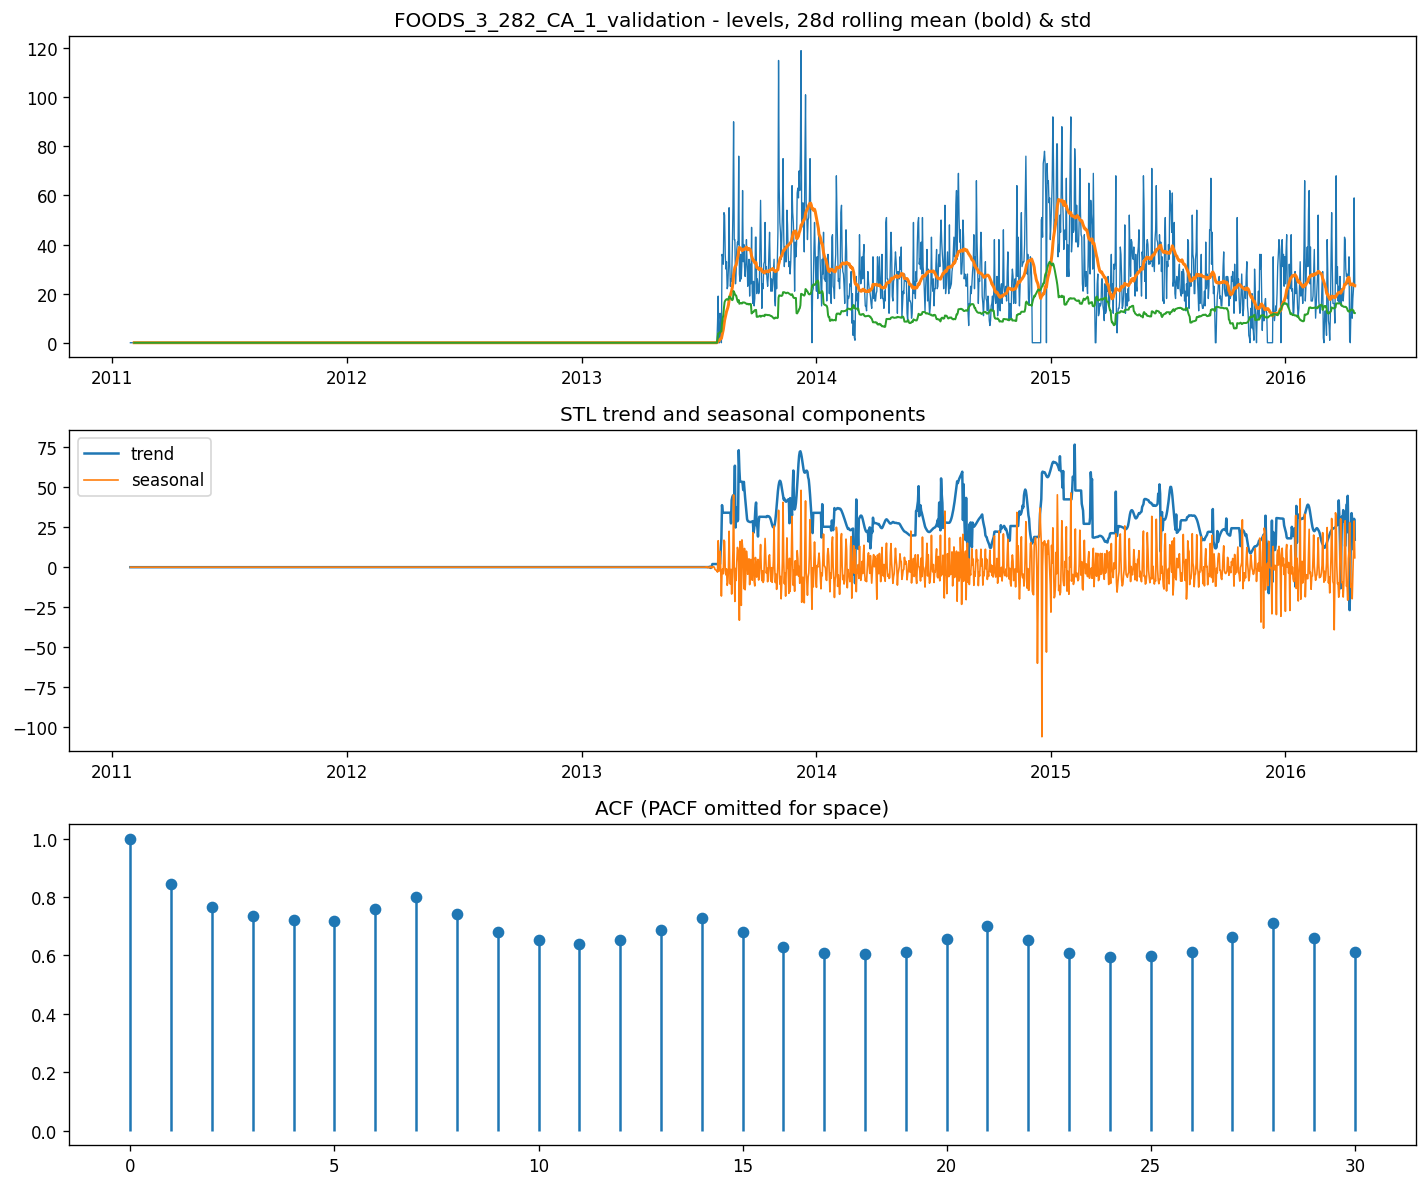

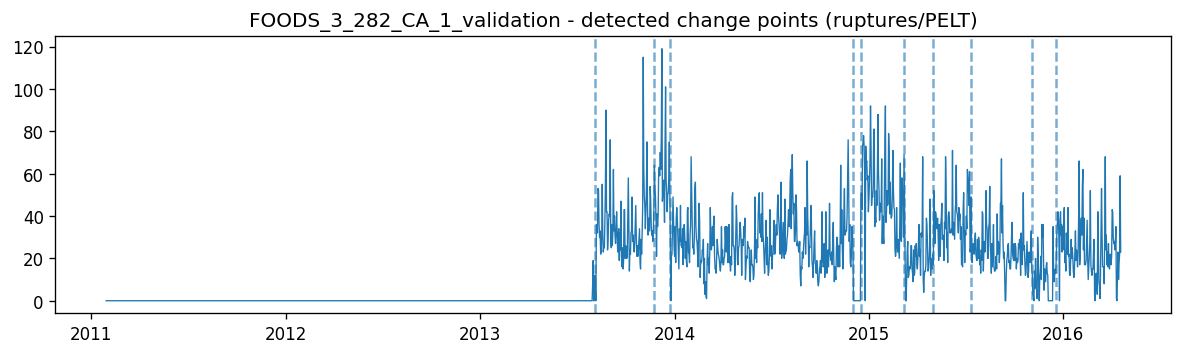

In [32]:
plot_series_diagnostics(top_ids[0])

The example time series FOODS_3_282_CA_1_validation shows clear signs of non-stationarity.

1st plot: The daily demand (blue) together with its 28-day rolling mean (orange) and rolling standard deviation (green) shows long periods of zero demand, followed by sudden level changes and varying peaks. Both the mean and the variability shift over time.

2nd plot: The STL decomposition separates the series into trend and seasonal parts. The trend component rises and falls at different times, while the seasonal component also changes in strength.

3rd plot: The autocorrelation function (ACF) stays high across many lags, which is another indication that the data do not have a constant mean and variance.

The last figure shows the series with detected change points obtained by the PELT algorithm. The solid line represents daily demand, and the vertical dashed lines mark estimated structural breaks. Several change points appear after demand starts in 2013 and continue through 2016. Each detected break indicates a shift in the level or variance of the demand process. The repeated changes confirm that the series does not follow a stable pattern over time.

Overall, the changing level, changing variability, multiple structural breaks, and strong serial dependence visible in the plot confirm the statistical test results and provide clear visual evidence that this demand series is non-stationary.

#### Few more plots to confirm that the above analysis holds for all the series.

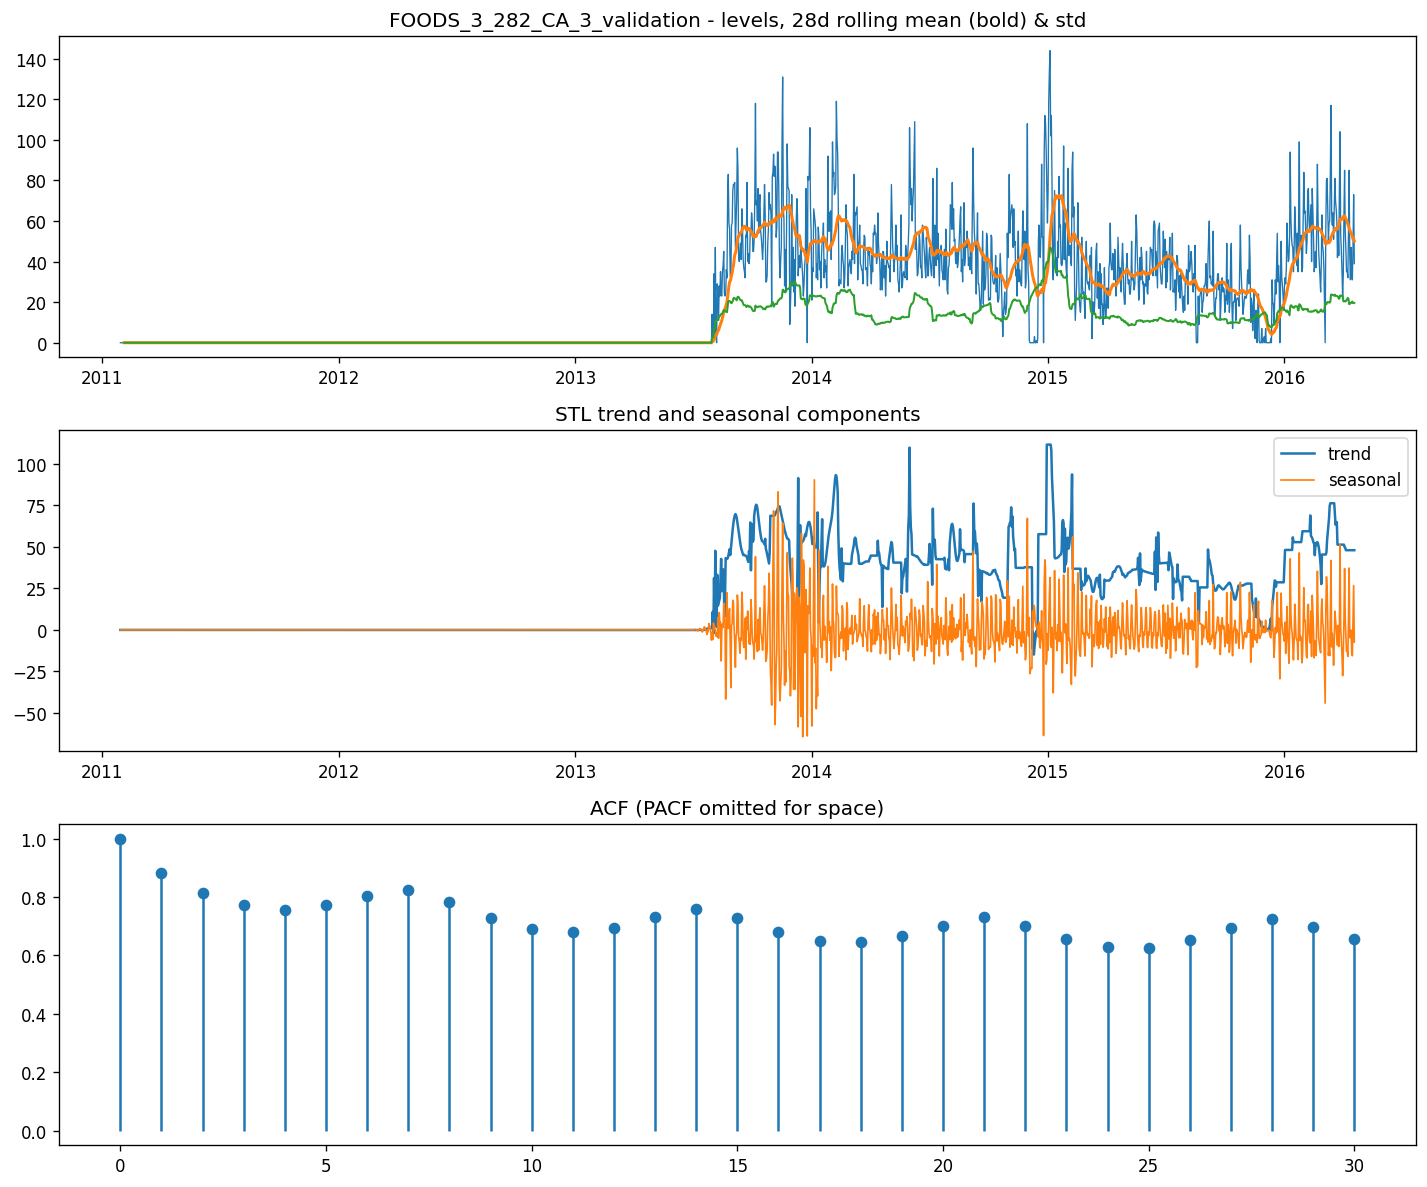

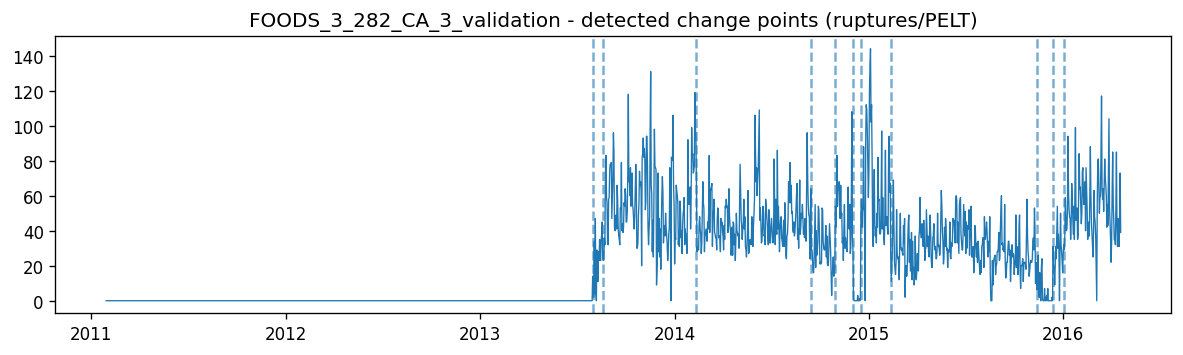

In [33]:
plot_series_diagnostics(top_ids[1])

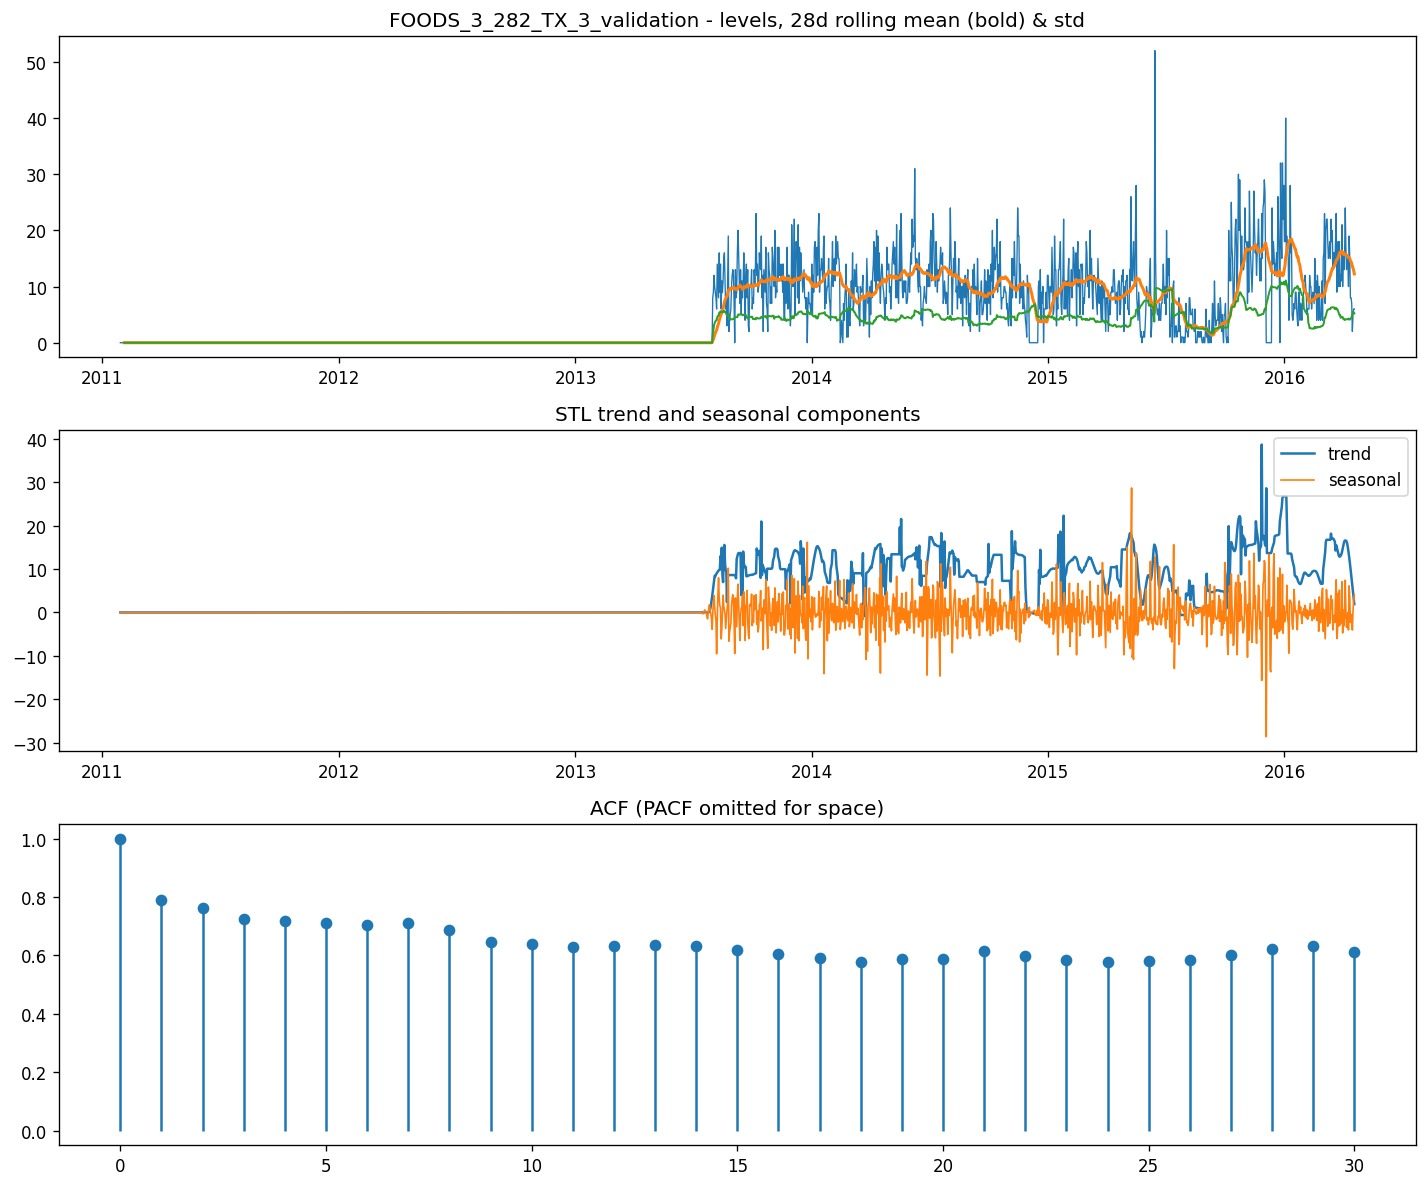

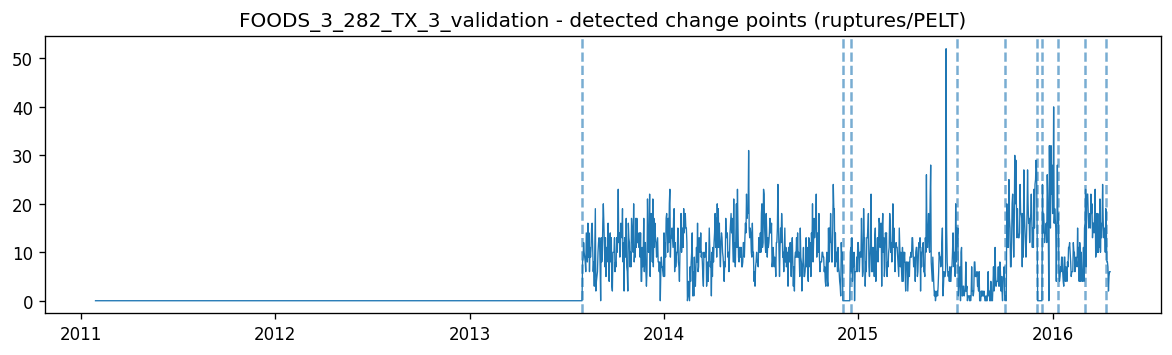

In [34]:
plot_series_diagnostics(top_ids[2])

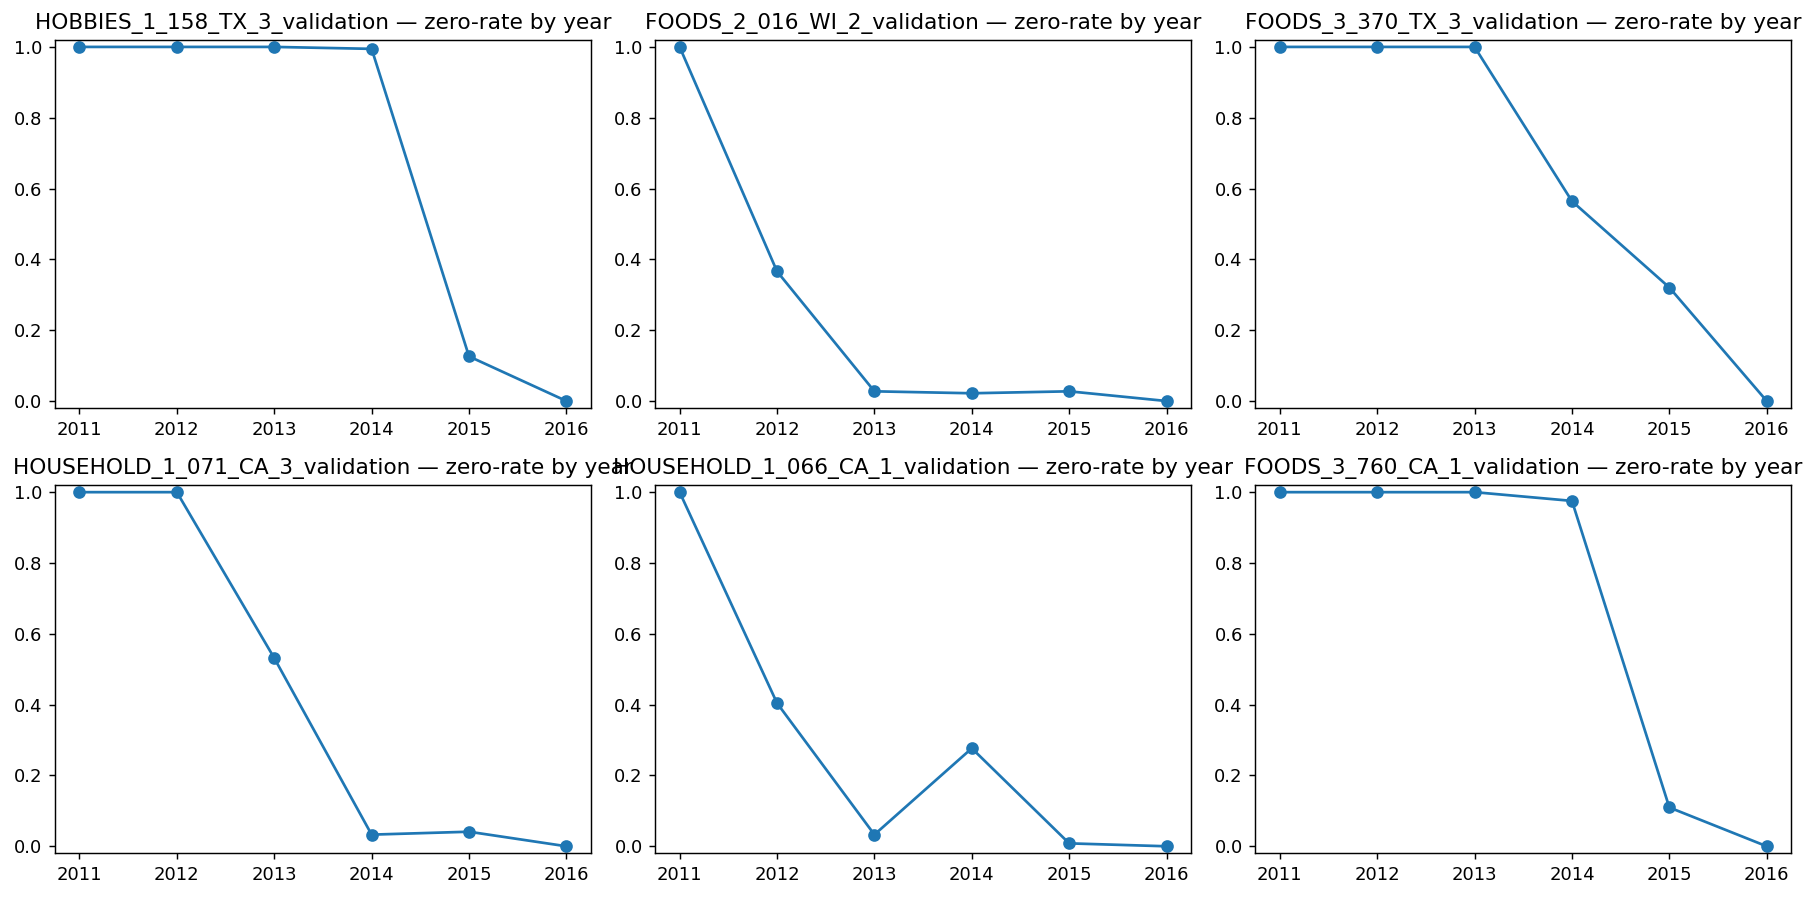

In [35]:
# Zero counts proportion and how it changes across years/halves
zs = (df.assign(is_zero=(df["sales"]<=0))
        .groupby(["id","year"], as_index=False)
        .agg(zero_rate=("is_zero","mean"), var=("sales","var"), mean=("sales","mean")))

# Visual: picking 6 ids with big year-to-year zero-rate swings
zs["yr_spread"] = zs.groupby("id")["zero_rate"].transform(lambda s: s.max()-s.min())
pick = (zs.sort_values("yr_spread", ascending=False)
          .drop_duplicates("id").head(6)["id"].tolist())

fig, axes = plt.subplots(2,3, figsize=(14,7), dpi=130)
axes = axes.ravel()
for ax, sid in zip(axes, pick):
    sub = zs[zs["id"]==sid]
    ax.plot(sub["year"], sub["zero_rate"], marker="o")
    ax.set_title(f"{sid} — zero-rate by year")
    ax.set_ylim(-0.02,1.02)
plt.tight_layout(); plt.show()


This plot shows the yearly zero-rate (share of days with zero demand) for several representative series. Each panel corresponds to one product–store combination.

In all panels the zero-rate starts close to 100 % and then drops sharply, but the timing and speed of the decline differ across products. These large, sudden changes in the proportion of zero-demand days indicate strong shifts in the underlying demand process.

Such variability confirms that the occurrence of zero sales is not stable over time and provides additional visual evidence of non-stationary demand with structural changes.

In [36]:
out = {}

# Unit-root summaries
alpha = 0.05
out["ADF_reject_rate"] = float(np.mean(unit_tests["ADF_p"] < alpha))
out["KPSS_c_reject_rate"] = float(np.mean(unit_tests["KPSS_c_p"] < alpha))
out["KPSS_ct_reject_rate"] = float(np.mean(unit_tests["KPSS_ct_p"] < alpha))
out["ZA_reject_rate"] = float(np.mean(unit_tests["ZA_p"] < alpha)) if HAS_ZA else np.nan
out["PP_reject_rate"] = float(np.mean(unit_tests["PP_p"] < alpha)) if HAS_PP else np.nan

# Distribution drift
out["KS_half_drift_rate"] = float(np.mean(shift_df["KS_p"] < 0.05))
out["CVM_half_drift_rate"] = float(np.mean(shift_df["CVM_p"] < 0.05))

# Yearly drift: share of (id,year) pairs significantly different from base year
if not year_drift.empty:
    out["year_vs_base_KS_sig_rate"] = float(np.mean(year_drift["KS_p"] < 0.05))

# Zero-inflation change spread (median across ids of (max-min) yearly zero-rate)
zr_spread = (zs.groupby("id")["zero_rate"].agg(lambda s: (s.max()-s.min()))).median()
out["median_zero_rate_yearly_spread"] = float(zr_spread)

summary_table = pd.Series(out).to_frame("value")
print(summary_table)


                                   value
ADF_reject_rate                 0.010000
KPSS_c_reject_rate              1.000000
KPSS_ct_reject_rate             0.996000
ZA_reject_rate                  0.724000
PP_reject_rate                       NaN
KS_half_drift_rate              0.980000
CVM_half_drift_rate             0.980000
year_vs_base_KS_sig_rate        0.700800
median_zero_rate_yearly_spread  0.788991


#### What each number shows:

ADF_reject_rate = 0.01: Almost none of the series look stationary under ADF.

KPSS_c_reject_rate = 1.00; KPSS_ct_reject_rate = 0.996: Stationarity is rejected for virtually all series, even after allowing a linear trend.

ZA_reject_rate = 0.724: A single break can explain many series, but not all. More than one break or additional non-stationarities are common.

KS_half_drift_rate = 0.98; CVM_half_drift_rate = 0.98: First versus second half distributions differ for about 98% of series, confirming strong drift over time.

year_vs_base_KS_sig_rate = 0.7008: About 70% of year–to–base-year comparisons show significant distributional change, indicating persistent reconfiguration across years.

median_zero_rate_yearly_spread = 0.789: The median series has a 78.9 percentage-point swing in the yearly share of zero-sales days, showing large shifts in zero inflation.

**Overall conclusion**: Demand is clearly non-stationary with strong distributional drift, multiple structural changes, and large shifts in zero inflation. Static models are not adequate.